<a href="https://colab.research.google.com/github/KasymalievaZhanel/Lab3_Dl_for_anytask/blob/main/Lab2_DL_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
print(text[:10])

['  From fairest creatures we desire increase,\n', "  That thereby beauty's rose might never die,\n", '  But as the riper should by time decease,\n', '  His tender heir might bear his memory:\n', '  But thou, contracted to thine own bright eyes,\n', "  Feed'st thy light's flame with self-substantial fuel,\n", '  Making a famine where abundance lies,\n', '  Thy self thy foe, to thy sweet self too cruel:\n', "  Thou that art now the world's fresh ornament,\n", '  And only herald to the gaudy spring,\n']


In [ ]:
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))
num_tokens = len(tokens)
print(num_tokens)

38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
assert len(token_to_idx) == len(idx_to_token)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.style.use('ggplot')


In [ ]:
MAX_LEN = 120
BATCH_SIZE = 200
NUM_BATCHES = (len(text) - MAX_LEN) // BATCH_SIZE

In [ ]:
def to_matrix(pieces, max_len=None):
  if max_len == None: 
    max_len = max(map(len, pieces))

  text_ix = np.zeros((len(pieces), max_len), dtype='int32')
  for i in range(len(pieces)): 
    line_ix = [token_to_idx[c] for c in pieces[i]]
    text_ix[i, :len(line_ix)] = line_ix
  return text_ix

In [ ]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True).to(device)

In [ ]:
def RNNLoop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
def get_next_str(num, start=0, piece_len=100, step=1):
  res = []
  for i in range(num): 
    if start + piece_len >= len(text) - 1:
      print("FFFFFF")
      break
    else :
      end = start + piece_len 
      res.append(text[start:end])
      start += step
  return res

In [ ]:
from tqdm import tqdm
from tqdm import trange
tqdm._instances.clear()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_epoch(opt, rnn) :
  current_epoch_loss = 0
  for batch_idx in trange(NUM_BATCHES):
    matr_str = to_matrix(get_next_str(BATCH_SIZE, start=batch_idx * BATCH_SIZE, piece_len=MAX_LEN))
    samples = torch.tensor(matr_str, dtype=torch.int64).to(device)
    batch_ix = samples[:, :-1]

    opt.zero_grad()
    logp_seq = RNNLoop(rnn, batch_ix)
    predictions_logp = logp_seq

    actual_next_tokens = samples[:, 1:]
    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
    loss = -logp_next.mean()
    
    current_epoch_loss += loss.detach().cpu().numpy()
    loss.backward()
    opt.step()
  return current_epoch_loss  

In [ ]:
def print_report(current_epoch_loss, epoch, loss_history) :
    print('Training epoch: {} Loss: {}'.format(epoch, current_epoch_loss))
    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()

In [ ]:
def training_loop(rnn, opt, epochs):
  loss_history = []
  for epoch in range(epochs):
    current_epoch_loss = train_epoch(opt, rnn)
    current_epoch_loss /= NUM_BATCHES
    loss_history.append(current_epoch_loss)
    print_report(current_epoch_loss, epoch, loss_history)
  return loss_history

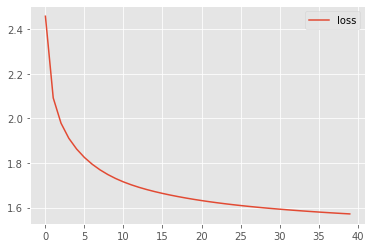

In [ ]:
char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
loss_history = training_loop(char_rnn, opt, 40)

In [ ]:
MAX_LEN = 100

In [ ]:
def generate_sample(char_rnn, seed_phrase='hello', max_length=MAX_LEN, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1)
  
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
  
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])   
            

In [ ]:
# An example of generated text.
print(generate_sample(char_rnn, seed_phrase='my friend', max_length=500, temperature=0.8))

my friend will forgernce to desself i will thou evind thee is my love, and fairs;
  though that i eye so my for thou sare to so that touchen this show hours they love love is plaves thy self be for even to mine and thou that exce pornes conthify,
  abp'd thee my comple was thy all thou thy art not vilve more sour in thee fecellact, was spert i to thy lov'd part
  with from my dear,
  if both not of thinks eyes,
  who mast is that i say my mence fair:
  thy mely due to hate the fick thou breason 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        h_next = self.rnn_update(x_emb, h_prev)
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next[0])
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return [torch.zeros(batch_size, self.num_units, requires_grad=True).to(device) for i in range(2)]

In [ ]:
lstm_rnn = LSTMCell().to(device)
lstm_opt = torch.optim.Adam(lstm_rnn.parameters())

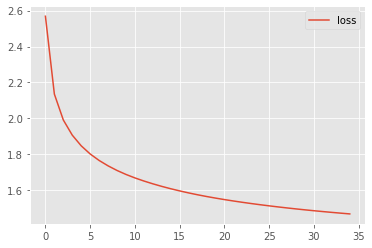

In [ ]:
loss_history_lstm = training_loop(lstm_rnn, lstm_opt, 35)

In [ ]:
print(generate_sample(lstm_rnn, seed_phrase='my friend', max_length=500, temperature=1))

my friends seal to,.
  xxciii

  whowh, which by they, not better and dote.
  o! her care strand lov'st chund to praise,
  long it what lies to thy hold can eyes precont
  many do ellled doth true,
  cundlatil'd upon a leal;
  to mysearion and bortlays past,
  that nighning tan eye more doth with this dear so;
  my arouthacoud thee hate;
  with thine uy. prove i save thom fan one breavtil with mine
  rity are his wrild a courr'd;
  sifift to sungety dewards thinemed to me,
  o! 'will-thy love i 


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='my friend', max_length=500, temperature=0.1))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='my friend', max_length=500, temperature=0.2))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='my friend', max_length=500, temperature=0.5))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='my friend', max_length=500, temperature=1))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='my friend', max_length=500, temperature=2))


***

my friend the state,
  the store the world the state the state the state,
  that i as the store the state that the state,
  that i the strand the state the state the state the state
  the world the world thou thou art the world the state,
  and the state the store the state the state the state,
  and thou thou thou thou thou thou thou art the state,
  that i have the state the state the state the state,
  and the state the world the state the state the state,
  the world the world that the world

***

my friend and thou thee,
  which i have the world and the world thou art the constance thee strength
  and the may the true the state, and the store i fair to thee all thee thee strength thee shown,
  that the world the true the world the sweet doth steel to me still dear thee thee,
  and the world thou thou thou thee strainst the store i have the world to me strange,
  the hath thy so thy stranguly my hath thee be doth thee strange,
  and the world that i all thee the state in the 

We can see that on low temperature (like 0.1) the net often repeats the same words (probably the most frequent) so the generated text mostly consists of "thee" and "the world". Not much fun, actually.

On 0.2 the situation is pretty similar, but there are more different words appearing, lines are usually shorter (that's good).

0.5 is nice, no weird repetitions and most of the words are real. It still does not make any sense, but that's not what we're here for.

1.0 is my fav here! Beautiful structure, lots of punctuation, some grammatically correct pieces can be found.

On 2.0 the net goes crazy and just messes everything up. No meaningful or at least readable words, punctuation everywhere.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
torch.save(lstm_rnn, 'model')
loaded = torch.load('model')

In [ ]:
print(generate_sample(loaded, seed_phrase='my friend', max_length=500, temperature=0.8))

my friend are for me now falled for this so aft to,
  yet guph that sweet mestants, now pern,
  and eyes and to praise i will his pread,
  since do yours of hasting seem thy love thou lie show,
    that desiry and in thine eye, and beauty's me thou,
  by love this to day, and i do infect stard,
    her thou thou me am the slander thy proves not from in these can delad to thou me.

  clii

  who mistere both self spees that that should desperal fangel am of eye,
  back for no were finding doth be


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)